In [32]:
import numpy as np
import pandas as pd 

## code de la fonction de génération de scénarios 

In [33]:


def sampleMF(var, fundmap, histMF, histAR, cholMF, dyn, n, stochastic=True):
    """
    Simule des scénarios trimestriels pour :
        • 5 facteurs macro (gdp, cpi, unemp, rate_3m, rate_10y)
        • 4 rendements de fonds (Obligataire, Actions, Monétaire, Immobilier)

    
    PARAMÈTRES
    
    var       : (5×6)   – 1re → 5e col = A1, 6e col = const
    fundmap   : (4×17)  – ordre : 15 betas, intercept, sigma
    histMF    : (≥2×5)  – historique macro (au moins 2 lignes)
    histAR    : (≥2×7)  – historique fonds  (seules 4 premières col. utilisées)
    cholMF    : (5×5)   – Cholesky des résidus macro
    dyn       : int     – nb de pas stochastiques avant de passer en déterministe
    n         : int     – horizon simulé (en trimestres)
    stochastic: bool    – True → tirages aléatoires, False → trajectoire moyenne
    --------------------------------------------------------------------------
    RETOUR
    ------
    ndarray de forme (n+1 , 9)  [5 macro + 4 fonds]
    """
    # -------- 1. Conversion numpy --------
    var      = np.asarray(var,      dtype=float)
    fundmap  = np.asarray(fundmap,  dtype=float)
    histMF   = np.asarray(histMF,   dtype=float)
    histAR   = np.asarray(histAR,   dtype=float)
    cholMF   = np.asarray(cholMF,   dtype=float)

    # -------- 2. Coefficients VAR --------
    A1, const = var[:, :5], var[:, 5]

    # -------- 3. Préparation des lags macro --------
    if histMF.shape[0] == 2:                         # seulement t-1 et t-0
        hmf_lags = np.vstack([histMF[0], histMF[0], histMF[1]])  # t-2 = t-1
    else:                                            # ≥3 lignes
        hmf_lags = histMF[-3:]

    # -------- 4. Point de départ --------
    hcurr = histMF[-1].copy()                        # macro t-0
    path  = [np.concatenate([hcurr, np.zeros(fundmap.shape[0])])]

    # -------- 5. Boucle de simulation --------
    for step in range(n):

        # 5-a. Bloc macro : VAR(1) + choc éventuel
        mu    = A1 @ hcurr + const
        eps   = cholMF @ np.random.randn(5) if stochastic else np.zeros(5)
        hnext = mu + eps

        # 5-b. Bloc fonds : régression linéaire + bruit idiosyncratique
        X = np.concatenate([hnext, hmf_lags[-1], hmf_lags[-2]])   # 15 facteurs
        betas      = fundmap[:, :15]
        intercepts = fundmap[:, 15]
        sigma      = fundmap[:, 16]
        det_part   = betas @ X
        rand_part  = np.random.randn(fundmap.shape[0]) * sigma if stochastic else 0
        anext      = det_part + intercepts + rand_part            # 4 rendements

        # 5-c. Mise à jour des lags et stockage
        hmf_lags = np.vstack([hmf_lags[1:], hnext])
        path.append(np.concatenate([hnext, anext]))
        hcurr = hnext.copy()

        # 5-d. Bascule éventuelle en déterministe après dyn pas
        if stochastic and step + 1 == dyn:
            stochastic = False

    return np.asarray(path)


## test de la fonction 

In [34]:

import numpy as np
import pandas as pd

#  Lire les fichiers CSV
df_var = pd.read_csv("var.csv", index_col=0) 
df_fundmap = pd.read_csv("mapping_matrix.csv", index_col=0)
histMF = pd.read_csv("histMF.csv")        
histAR = pd.read_csv("histAR.csv")        
cholMF = pd.read_csv("var1chol.csv") 

# Transformer en matrices numpy
var      = df_var.values                  # (5×6)
fundmap  = df_fundmap.values              # (4×17)
histMF   = histMF.values                  # (2×5)
histAR   = histAR.values                 
cholMF = cholMF.values.astype(float)       # (5×5)


#  simulation de 40 trimestres (10 ans)
result = sampleMF(
    var=var,
    fundmap=fundmap,
    histMF=histMF,
    histAR=histAR,
    cholMF=cholMF,
    dyn=0,            # tout stochastique
    n=40,             # 40 trimestres simulés
    stochastic=True
)


print("Résultat shape :", result.shape)  # (41, 9)


print(pd.DataFrame(result).head())


Résultat shape : (41, 9)
              0           1          2         3         4         5  \
0  29962.047000  319.615000   4.200000  4.200000  4.280000  0.000000   
1  22877.702607  145.028811 -18.848922 -0.813478  9.201434 -0.348226   
2   9311.708252   73.157925  -7.334185 -0.330098  6.175288 -0.011614   
3   4309.133503   33.941984  -3.434856  0.299184  3.197370 -0.025171   
4   2178.838378   17.292493  -2.388480  0.514710  1.027795  0.027674   

          6         7         8  
0  0.000000  0.000000  0.000000  
1 -1.512631 -0.022796  0.073409  
2  0.045326  0.020437 -0.347717  
3 -0.316946 -0.002785 -0.210021  
4 -0.327980 -0.000681 -0.087278  


In [35]:
columns = [
    "gdp", "cpi", "unemp", "rate_3m", "rate_10y",
    "fond_obligataire", "actions", "monétaire", "immobilier"
]

df_result = pd.DataFrame(result, columns=columns)
print(df_result.head())


            gdp         cpi      unemp   rate_3m  rate_10y  fond_obligataire  \
0  29962.047000  319.615000   4.200000  4.200000  4.280000          0.000000   
1  22877.702607  145.028811 -18.848922 -0.813478  9.201434         -0.348226   
2   9311.708252   73.157925  -7.334185 -0.330098  6.175288         -0.011614   
3   4309.133503   33.941984  -3.434856  0.299184  3.197370         -0.025171   
4   2178.838378   17.292493  -2.388480  0.514710  1.027795          0.027674   

    actions  monétaire  immobilier  
0  0.000000   0.000000    0.000000  
1 -1.512631  -0.022796    0.073409  
2  0.045326   0.020437   -0.347717  
3 -0.316946  -0.002785   -0.210021  
4 -0.327980  -0.000681   -0.087278  


In [36]:
df_result.to_csv("scenarios_simules.csv", index=False)


In [37]:
# affichage de scenarios_simules.csv
scenarios = pd.read_csv("scenarios_simules.csv")
scenarios


,gdp,cpi,unemp,rate_3m,rate_10y,fond_obligataire,actions,monétaire,immobilier
0,29962.047000,319.615000,4.200000,4.200000,4.280000,0.000000,0.000000,0.000000,0.000000
1,22877.702607,145.028811,-18.848922,-0.813478,9.201434,-0.348226,-1.512631,-0.022796,0.073409
2,9311.708252,73.157925,-7.334185,-0.330098,6.175288,-0.011614,0.045326,0.020437,-0.347717
3,4309.133503,33.941984,-3.434856,0.299184,3.197370,-0.025171,-0.316946,-0.002785,-0.210021
4,2178.838378,17.292493,-2.388480,0.514710,1.027795,0.027674,-0.327980,-0.000681,-0.087278
5,919.005400,9.582581,-0.188387,0.599744,0.944400,0.010920,-0.259131,-0.001236,-0.027848
6,814.966755,5.155752,-1.108544,-0.197086,-0.207596,0.046609,-0.138054,-0.002240,-0.014979
7,598.545507,4.327865,-0.329669,-0.257675,0.103360,0.042092,-0.110000,-0.002299,-0.013075
8,406.373387,2.841946,-0.138313,-0.236302,0.422955,0.040470,-0.155602,-0.008171,0.032222
9,271.160731,1.210233,-0.817925,0.834562,0.397994,0.038455,-0.205987,-0.005987,-0.021796


In [ ]:
# 1000 scénarios 

## fonction d'interpolation–extrapolation de la courbe de taux zéro-coupon

In [38]:
import numpy as np
from scipy.interpolate import interp1d

def curve_fitting(rates, maturities=np.array([0.25, 1, 2, 3, 5, 7, 10, 20, 30]),
                  interpolation="linear", extrapolation="cfr", long_term_rate=0.04):
    """
    Génére une courbe de taux complète  à partir de points discrets.

    Paramètres :
    - rates : np.array – taux observés (ex: [0.01, 0.012, ...])
    - maturities : np.array – maturités correspondantes (ex: [0.25, 1, 2, ...])
    - interpolation : "linear" ou "cubic" – méthode d'interpolation entre les points
    - extrapolation : "cfr" ou "poly" – méthode d'extrapolation après la dernière maturité
    - long_term_rate : float – taux cible à 100 ans si extrapolation = "poly"

    Retourne :
    - maturité_complete, taux_complet : deux vecteurs numpy de même longueur
    """

    t_min = maturities[0]
    t_max = maturities[-1]
    t_before_last = maturities[-2]

    # 1. Interpolation : trimestrielle jusqu'à la dernière maturité observée
    maturité_interpolée = np.linspace(t_min, t_max, int(round((t_max - t_min) * 4 + 1))) # Crée un vecteur numpy contenant n points entre t_min et t_max inclus.
    interpolation_fonction = interp1d(maturities, rates, kind=interpolation)
    taux_interpolé = interpolation_fonction(maturité_interpolée)

    # 2. Extrapolation jusqu'à 100 ans
    maturité_extrapolée = np.linspace(t_max + 0.25, 100, int(round((100 - t_max) * 4)))
    taux_extrapolé = []

    if extrapolation == "cfr":
        dernier_taux = rates[-1]
        avant_dernier_taux = rates[-2]
        taux_forward_const = ((1 + dernier_taux) ** t_max / (1 + avant_dernier_taux) ** t_before_last) ** (1 / (t_max - t_before_last)) - 1
        facteur_cumulé = (1 + dernier_taux) ** t_max
        for t in maturité_extrapolée:
            facteur_cumulé *= (1 + taux_forward_const) ** 0.25
            taux_extrapolé.append(facteur_cumulé ** (1 / t) - 1)
    else:
        # extrapolation polynomiale de degré 2
        coefficients_poly = np.polyfit(
            [t_before_last, t_max, 100],
            [rates[-2], rates[-1], long_term_rate],
            deg=2
        )
        polynome = np.poly1d(coefficients_poly)
        taux_extrapolé = polynome(maturité_extrapolée)

    # 3. Fusion des résultats
    maturité_complete = np.concatenate([maturité_interpolée, maturité_extrapolée])
    taux_complet = np.concatenate([taux_interpolé, taux_extrapolé])

    return maturité_complete, taux_complet


##  test de la fct curve_fitting

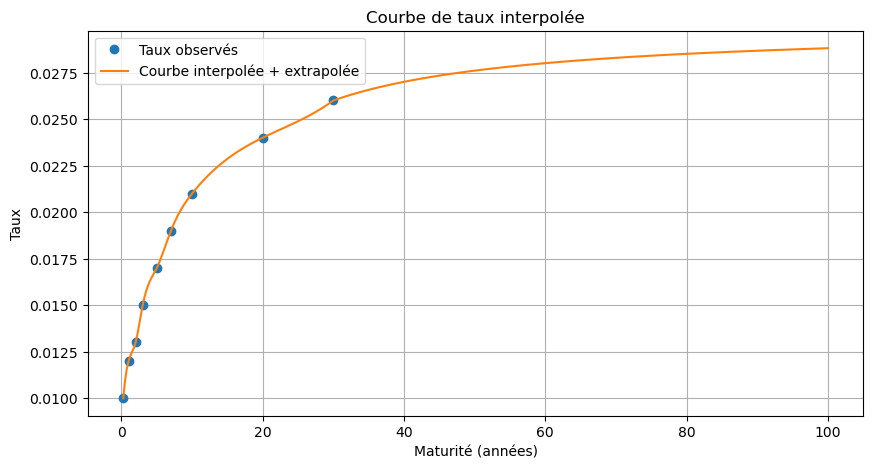

In [40]:

import numpy as np
import matplotlib.pyplot as plt


taux_observés = np.array([0.01, 0.012, 0.013, 0.015, 0.017, 0.019, 0.021, 0.024, 0.026])  
maturités_observées = np.array([0.25, 1, 2, 3, 5, 7, 10, 20, 30])  # en années

x, y = curve_fitting(
    rates=taux_observés,
    maturities=maturités_observées,
    interpolation="cubic",       # ou "linear"
    extrapolation="cfr",         
    long_term_rate=0.04          # taux cible à 100 ans (si poly)
)

# 3. Affichage graphique 
plt.figure(figsize=(10,5))
plt.plot(maturités_observées, taux_observés, "o", label="Taux observés")
plt.plot(x, y, label="Courbe interpolée + extrapolée")
plt.xlabel("Maturité (années)")
plt.ylabel("Taux")
plt.title("Courbe de taux interpolée")
plt.grid(True)
plt.legend()
plt.show()


## valoriser une obligation fixe à partir de la courbe de taux zéro qu on onbtient avec  curve_fitting.

In [42]:

# Calculer la valeur actuelle d’une obligation en actualisant tous ses flux futurs (coupons + remboursement final) avec les taux d’intérêt zéro-coupon du marché.
import numpy as np
from scipy.interpolate import interp1d

def bond_price(zero_maturities,
               zero_rates,
               maturity,                 # durée de vie totale de l’obligation (années)
               coupon_rate,
               freq=1,                   # fréquence des coupons (1 = annuel, 2 = semestriel, 4 = trimestriel)
               redemption=100,
               interp_kind="linear",
               extrap_kind="cfr",
               long_rate_target=0.04):
    """
    Calcule le prix théorique (clean price) d'une obligation à taux fixe.

    Paramètres
    ----------
    zero_maturities  : np.array – maturités des points zéro (ex. [0.25, 1, 2, ...])
    zero_rates       : np.array – taux zéro correspondants (en décimal)
    maturity         : float    – maturité finale de l'obligation (en années)
    coupon_rate      : float    – coupon nominal annuel (ex. 0.03 pour 3 %)
    freq             : int      – nombre de paiements de coupon par an
    redemption       : float    – valeur nominale remboursée à l'échéance
    interp_kind      : "linear" ou "cubic"
    extrap_kind      : "cfr" ou "poly"
    long_rate_target : float    – taux cible à 100 ans si extrap_kind="poly"

    Retour
    ------
    float – prix théorique de l'obligation
    """

    #   Construction de la courbe zéro-rates complète (trimestrielle jusqu’à 100 ans)
    times, zero_curve = curve_fitting(
        rates=zero_rates,
        maturities=zero_maturities,
        interpolation=interp_kind,
        extrapolation=extrap_kind,
        long_term_rate=long_rate_target
    )

    # Interpolateur continu R(t) pour lire le taux zéro à n’importe quelle maturité
    R = interp1d(times, zero_curve, kind="linear", fill_value="extrapolate")

    #  Calendrier des flux de coupon
    dt   = 1 / freq                        # pas entre coupons
    n_cf = int(round(maturity * freq))     # nombre total de coupons
    cashflow_times = np.arange(dt, n_cf*dt + 1e-9, dt)   

    #  Prix = somme des coupons actualisés + remboursement actualisé
    pv = 0.0
    for t in cashflow_times[:-1]:          # tous sauf le dernier
        pv += redemption * coupon_rate / freq / (1 + R(t))**t
    # dernier flux = coupon + redemption
    T  = cashflow_times[-1]
    pv += redemption * (1 + coupon_rate / freq) / (1 + R(T))**T

    return pv
